<a href="https://colab.research.google.com/github/AbiDSukumaran/label_any_dataset/blob/main/incident_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install wordcloud

In [ ]:
pip install lxml

In [ ]:
pip install pyodbc

In [ ]:
pip install spacy

In [ ]:
pip install bs4

In [ ]:
pip install nltk

In [ ]:
pip install tensorflow

In [ ]:
pip install torch==1.5.0

In [ ]:
pip install torchvision==0.6.0

In [ ]:
pip install transformers==3.4.0

In [ ]:
pip install bert-extractive-summarizer

In [ ]:
!python -m spacy download en_core_web_sm

In [ ]:
!pip install summarizer

This notebook has the list of steps for extracting and preprocessing your data set in preparation for Vertex AI models.

In [ ]:
#@title Import dependencies

import re
import string
import os
import sys
import pyodbc
import pandas as pd
import numpy as np
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from bs4 import BeautifulSoup
import unicodedata
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from tqdm import tqdm
from summarizer import Summarizer
model = Summarizer()

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
import nltk
from nltk.util import ngrams

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
stopwords -= {"do", "no", "not", "see", "cannot", "off", "show"}

In [ ]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [ ]:
#@title Method to get word counts
def get_wordcounts(x):
    length = len(str(x).split())
    return length


In [ ]:
def get_charcounts(x):
    s = x.split()
    x = ''.join(s)
    return len(x)

In [ ]:
def get_avg_wordlength(x):
    if get_wordcounts(x) > 0:
        count = get_charcounts(x)/get_wordcounts(x)
    else:
        count = get_charcounts(x)
    return count

In [ ]:
def get_stopwords_counts(x):
    l = len([t for t in x.split() if t in stopwords])
    return l

In [ ]:
def get_hashtag_counts(x):
    l = len([t for t in x.split() if t.startswith('#')])
    return l

In [ ]:
def get_mentions_counts(x):
    l = len([t for t in x.split() if t.startswith('@')])
    return l

In [ ]:
def get_digit_counts(x):
    return len([t for t in x.split() if t.isdigit()])

In [ ]:
def get_kb_number(x):
#     x = x.lower()
    return  re.findall(r'(kb[0-9]{6,})', x)

In [ ]:
def get_uppercase_counts(x):
    return len([t for t in x.split() if t.isupper()])

In [ ]:
#@title Method to remove HTML tags
def remove_html_tags(x):
    return BeautifulSoup(x, 'lxml').get_text().strip()

In [ ]:
#@title Method to define and expand words
def cont_exp(x):
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how does",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not"
    }

    if type(x) is str:
        for key in contractions:
            value = contractions[key]
            x = x.replace(key, value)
        return x
    else:
        return x

In [ ]:
#@title Method to extract emails
def get_emails(x):
    emails = re.findall(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+\b)', x)
    counts = len(emails)

    return counts, emails

In [ ]:
def remove_emails(x):
    return re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)',"", x)

In [ ]:
def get_urls(x):
    urls = re.findall(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', x)
    urls.extend(re.findall(r'([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', x))
    counts = len(urls)

#     return counts, 
    return urls

In [ ]:
def remove_urls(x):
    x = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , x)
    return x

In [ ]:
def remove_rt(x):
    return re.sub(r'\brt\b', '', x).strip()

In [ ]:
#@title Method to remove nulls
def remove_na(x):
    x = re.sub(r'\bna\b', '', x).strip()
    x = re.sub(r'\bn\b', '', x).strip()
    return x

In [ ]:
def remove_whitespaces(x):
    x = re.sub(' +', ' ', x)
    return x

In [ ]:
def remove_common_text_postsummaryprocess(x):
    utext = remove_hi(x) 
    utext = remove_user(utext)
    return utext

In [ ]:
#@title Method to remove digits
def remove_digits(text):
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    return re.sub(pattern, '', text)
    
def remove_special_characters(text):
    # define the pattern to keep
    text = text.replace("_","")
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    return re.sub(pat, '', text)

In [ ]:
#@title Method to remove special characters
def remove_special_chars(x):
    x = re.sub(r'[^\w ]+', "", x)
    x = ' '.join(x.split())
    return x

In [ ]:
#@title Method to remove accented characters
def remove_accented_chars(x):
    x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return x

In [ ]:
#@title Method to remove stop words
def remove_stopwords(x):
    return ' '.join([t for t in x.split() if t not in stopwords])

In [ ]:
def make_base(x):
    x = str(x)
    x_list = []
    doc = nlp(x)

    for token in doc:
        if token.text not in ['feeds', 'leads', 'teams', 'tasks', 'events', 'dashboards', 'reports', 'cases', 'opportunities', 'ideas','courses','credentials', 'files', 'windows', 'notifications', 'managed', 'learning', 'logging','stuck', 'locked']:
            lemma = token.lemma_
#             print(lemma)
            if lemma == '-PRON-' or lemma == 'be':
                lemma = token.text
        else:
            lemma = token.text

        x_list.append(lemma)
    return ' '.join(x_list)

In [ ]:
#@title Method to get unique statements
# def get_unique_sentences(number, x):
def get_unique_sentences(x):
#     print(number)
    x = str(x)
    x_list = []
    doc = nlp(x)
    
    #for doc in docs:
    for i, token in enumerate(doc.sents):
        if token.text.strip() not in x_list:
            x_list.append(token.text.strip())

    return ' '.join(x_list)

In [ ]:
#@title Method to get sentence count
def get_sentence_count(x):
    x = str(x)
    doc = nlp(x)
    return len(list(doc.sents))

In [ ]:
#@title Method to summarize text
def get_summary(x):
  sc = get_sentence_count(x)
  if sc <= 4:
      summary = x
  else:
      summary = model(x)
  return summary

In [ ]:
print(get_summary("Hello this is a new beginning. There is. always. light."))

Hello this is a new beginning. There is. always. light.


In [ ]:
def get_value_counts(df, col):
    text = ' '.join(df[col])
    text = text.split()
    freq = pd.Series(text).value_counts()
    return freq

In [ ]:
def remove_common_words(x, freq, n=20):
    fn = freq[:n]
    x = ' '.join([t for t in x.split() if t not in fn])
    return x

In [ ]:
def remove_rarewords(x, freq, n=20):
    fn = freq.tail(n)
    x = ' '.join([t for t in x.split() if t not in fn])
    return x

In [ ]:
#@title Method to check spelling
def spelling_correction(x):
    retvalue = []
    value = ''
    spell = SpellChecker()
    if x:
        x = ''.join(x)
        x = x.split(' ')
        misspelled = spell.unknown(x)
        for allword in x:
            if allword in misspelled:
                # Get the one `most likely` answer
                if allword not in (['okta','vpn', 'prehire', 'apac', 'ssrs', 'cva', 'cvd', 'ad', 'rdp','thycotic', 'vdi', 'wfm', 'runtime' ]):
                    value = spell.correction(allword)
                else:
                    value = allword
                # Get a list of `likely` options
            else:
                value = allword
            retvalue.append(value)         
        return ' '.join(retvalue)   
    else:
        return x

In [ ]:
def replace_single_character(x):
    return re.sub(r"\b[a-zA-Z]\b", "", x)

In [ ]:
def punct(text):
    token = RegexpTokenizer(r'\w+')
    # from token to alphabetic sequences
    text = token.tokenize(text)
    text = " ".join(text)
    return text

In [ ]:
import pandas as pd
df = pd.read_csv('/content/sample_data/comcast_consumeraffairs_complaints.csv')
df = df[['text']]
df = df.dropna()

In [ ]:
df['cleaned_issue_description'] = df['text']

In [ ]:
!pip install summarizers

In [ ]:
from summarizers import Summarizers
summ = Summarizers()

In [ ]:
print(summ("When I called the infinity customer service center to complain about the new slow performance speed the first question customer service asked was How fast is it now and why didn't you buy the previous offer for the faster service. I responded with What speed is my plan am I paying for now. I explained to customer service the actual test was less than half that. The customer service rep said she would resend a signal to my router. No improved speed occurred. I am getting screw from Comcast/Xfinity I turned on my hotspot on my cell phone to file this complaint. I am getting screw from Comcast/Xfinity. My internet speed is not what I pay for."))

"I am getting screw from Comcast/Xfinity"


In [ ]:
#@title Invoke preprocessing methods
#Invoke preprocessing methods one by one

In [ ]:
df['cleaned_issue_description'] = df['cleaned_issue_description'].apply(lambda x: cont_exp(x))

In [ ]:
df['cleaned_issue_description'] = df['cleaned_issue_description'].apply(lambda x: get_unique_sentences(x))

In [ ]:
#df['sentence_count'] = df['cleaned_issue_description'].apply(lambda x: get_sentence_count(x))

In [ ]:
df['summary'] = df['te']

In [ ]:
df['summary'] = df['summary'].apply(lambda x: remove_special_characters(x))

In [ ]:
df['cleaned_issue_description'] = df['cleaned_issue_description'].apply(lambda x: remove_digits(x))
df['cleaned_issue_description_postprocess'] = df['cleaned_issue_description'].apply(lambda x: remove_digits(x))

In [ ]:
df['cleaned_issue_description'] = df['cleaned_issue_description'].apply(lambda x: punct(x))
df['cleaned_issue_description_postprocess'] = df['cleaned_issue_description_postprocess'].apply(lambda x: punct(x))

In [ ]:
df['cleaned_issue_description'] = df['cleaned_issue_description'].apply(lambda x: remove_accented_chars(x))
df['cleaned_issue_description_postprocess'] = df['cleaned_issue_description_postprocess'].apply(lambda x: remove_accented_chars(x))

In [ ]:
df['cleaned_issue_description'] = df['cleaned_issue_description'].apply(lambda x: replace_single_character(x))
df['cleaned_issue_description_postprocess'] = df['cleaned_issue_description_postprocess'].apply(lambda x: replace_single_character(x))

In [ ]:
df['cleaned_issue_description'] = df['cleaned_issue_description'].apply(lambda x: remove_special_characters(x))
df['cleaned_issue_description_postprocess'] = df['cleaned_issue_description_postprocess'].apply(lambda x: remove_special_characters(x))

In [ ]:
df['word_count'] = df['cleaned_issue_description'].apply(lambda x: get_wordcounts(x))

In [ ]:
df['char_count'] = df['cleaned_issue_description'].apply(lambda x: get_charcounts(x))

In [ ]:
df['average_word_length'] = df['cleaned_issue_description'].apply(lambda x: get_avg_wordlength(x))

In [ ]:
#@title Join all input texts to form one big input string
text = ' '.join(df['cleaned_issue_description'])

In [ ]:
import nltk
nltk.download('punkt')> nltk.download('punkt')

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

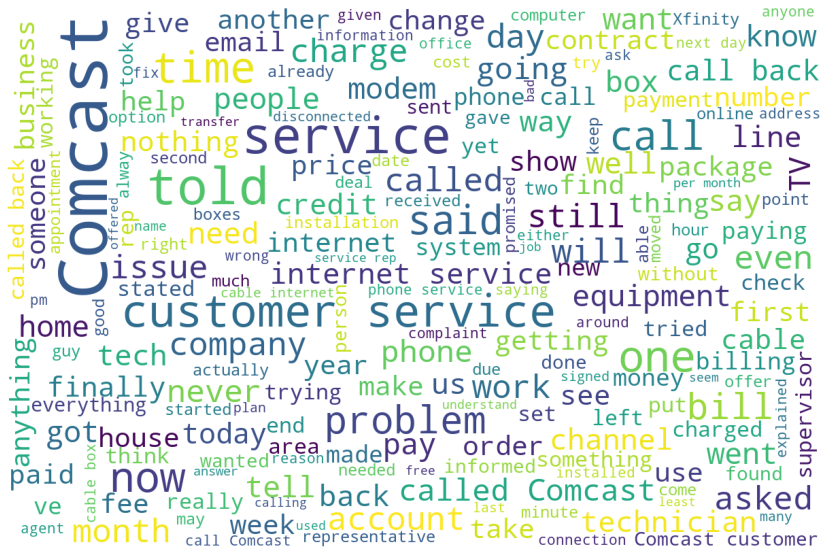

In [ ]:
#@title Generate Word Cloud to analyze the context and key intents
if text:
    wc = WordCloud(width=1200, height=800, max_font_size=100, background_color="white").generate(text)
    plt.figure(figsize=(20,10))
    plt.imshow(wc)
    plt.axis('off')
    plt.show()
    

In [ ]:
from pprint import pprint

In [ ]:
#@title List Word Cloud words with their weight in descending order and pick top 5-10 for labeling
key_value = WordCloud().process_text(text)
pprint(sorted(key_value.items(), key =
             lambda kv:(kv[1], kv[0])))  

In [ ]:
def generateWC(text):
  keys = []
  key_value = WordCloud().process_text(text)
  for key in key_value:
    keys.append(key)
  return keys


In [ ]:
checkdf = df.copy()

In [ ]:
#@title Top Intents identified
issuelist = ['Speed Issue', 'Interruption', 'Poor Service', 'Overcharge']


In [ ]:
#@title Create label dictionary
issuedict = {
    'Speed Issue' : [
    'slow', 'speed', 'running', 'internet speed', 'speed internet', 'high speed' 
    ],
    'Interruption' : [
    'broken', 'reset', 'failed', 'network', 'trouble', 'connect', 'internet connection', 'wifi','internet cable', 'router', 'disconnect', 'outage', 'signal', 'disconnected'
    ],
    'Poor Service' : [
    'multiple time', 'poor service', 'scheduled appointment', 'suck', 'customer support', 'stupid', 'showed called', 'treated', 'poor customer', 'weeks later', 'missed', 'service time', 'frustrating', 'Comcast worst', 
    'worst company', 'incompetent', 'Comcast technician', 'early termination',  'frustration', 'termination fee', 'worse', 'service center', 'horrible', 'service tech', 'frustrated', 'resolve issue', 'Comcast rep', 
    'canceled', 'basic cable', 'switched', 'upset', 'service representative', 'tech support', 'ticket', 'support', 'repair', 'installer', 'TV service', 'Verizon', 'ridiculous', 'hours phone', 'refused', 'promise',  
    'cancel service', 'cancelled', 'speak supervisor', 'employee', 'mistake', 'rude', 'lie', 'complaint', 'customer service'
    ],
    'Overcharge' : [
    'overcharged',  'overcharge', 'afford', 'pricing', 'told pay', 'paying month', 'fraud', 'frustrating', 'installation fee', 'late fee', 'collection agency', 'credited', 'monthly bill', 'owed', 'paid bill', 
    'claim', 'got bill', 'balance', 'agreement', 'contract', 'bill month', 'billed', 'dollar', 'received bill', 'charging', 'refund', 'rate', 'pay bill', 'billing', 'paying', 'charged', 'price', 'fee', 'paid', 
    'payment', 'pay', 'charge'
    ]
}

In [ ]:
#@title Helper Method: If text matches a dictionary value, return its key
def textcheck(text):
  for key, val in issuedict.items():
    if text in val:
      return key
  return ''

In [ ]:
#@title Generate Word Cloud for each input text in your sample
checkdf['Workd_Cloud_Each'] = checkdf['cleaned_issue_description_postprocess'].apply(lambda x: generateWC(x))

In [ ]:
#@title If individual texts Word Cloud words are present in the labeled list, assign that label
label = []
for i in checkdf.index:
  text = checkdf['Workd_Cloud_Each'][i]
  for texts in text:
    temp = textcheck(texts)
    if temp != '':
      label.append(temp)
      checkdf['label'][i] = temp
      break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
checkdf = checkdf.dropna()

4940
4940


In [ ]:
JSONtext = ''.join(checkdf['cleaned_issue_description_postprocess'])

In [ ]:
#@title Method to convert list into dictionary for JSONL format result
def convert(lst):
    result_dict = {lst[i]: lst[i + 1] for i in range(0, len(lst), 2)}
    return result_dict

In [ ]:
pip install jsonlines

In [ ]:
#@title Loop through input and Write into JSONL file in append mode
import jsonlines
result_lists = []
result = {}
result1 = {}
result2 = {}
result_super = {}

for index in checkdf.index:
    result_list = []
    result_list1 = []
    result_list2 = []


    result_list1.append("displayName")
    result_list1.append(checkdf['label'][index])
    result1 = convert(result_list1)

    result_list2.append("classificationAnnotation")
    result_list2.append(result1)
    result2 = convert(result_list2)

    result_list.append("textContent")
    result_list.append(checkdf['cleaned_issue_description_postprocess'][index])
    result = convert(result_list)

    result_super = {**result2, **result}

    with jsonlines.open('customer_incidents_lines.jsonl', mode='a') as writer:
      writer.write(result_super)
      writer.write("\n")



'''
list_textSegmentAnnotation = []
list_textSegmentAnnotation.append("textContent")
list_textSegmentAnnotation.append(JSONtext)
list_textSegmentAnnotation.append("textSegmentAnnotations")
list_textSegmentAnnotation.append(result_lists)
result = convert(list_textSegmentAnnotation)
'''

'\nlist_textSegmentAnnotation = []\nlist_textSegmentAnnotation.append("textContent")\nlist_textSegmentAnnotation.append(JSONtext)\nlist_textSegmentAnnotation.append("textSegmentAnnotations")\nlist_textSegmentAnnotation.append(result_lists)\nresult = convert(list_textSegmentAnnotation)\n'

In [ ]:
import jsonlines

with jsonlines.open('customer_incidents_lines.jsonl', mode='a') as writer:
    writer.write(result_lists)